In [1]:
%run data.ipynb
%run preprocessing.ipynb

You should consider upgrading via the '/home/leoasad/.pyenv/versions/3.8.12/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


[nltk_data] Downloading package punkt to /home/leoasad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/leoasad/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [3]:
data = get_tweets_and_reddit()

data.loc[:,'text'] = clean_text(data['text'])

In [20]:
data.to_csv('../../raw_data/twitter_reddit_clean.csv')

In [4]:
data['label'].value_counts()

0    12684
1    12684
Name: label, dtype: int64

# Holdout method

In [5]:
from sklearn.model_selection import train_test_split

X = data['text'].values
y= data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# Model baseline

In [6]:
# Create Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

cross_val_score(estimator=pipeline,
               X=X_train,
               y=y_train,
               scoring='f1',
               cv=5,
               n_jobs=-1).mean()

0.9012587273597656

# Tunning Model

In [7]:
pipeline.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'verbose': False,
 'tfidf': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None,

In [13]:
params = {
    'tfidf__max_df': [1.0,0.8],
    'tfidf__max_features' : [None,100,1000],
    'tfidf__min_df': [1,0.5],
    'tfidf__ngram_range': [(1,1),(1,2)],
    'nb__alpha': [1]
}

search = GridSearchCV(estimator=pipeline,
                     n_jobs=-1,
                     scoring='f1',
                     param_grid=params)

search.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                      

In [14]:
search.best_params_

{'nb__alpha': 1,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': 1000,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2)}

In [15]:
search.best_score_

0.9171027369446796

# Test the model in the test set

In [17]:
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)

f1_score(y_test, y_pred)

0.9202744853399876

## Classification Report

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      3805
           1       0.88      0.97      0.92      3806

    accuracy                           0.92      7611
   macro avg       0.92      0.92      0.92      7611
weighted avg       0.92      0.92      0.92      7611



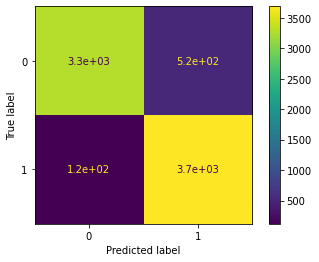

In [21]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(estimator=best_model,
                     X=X_test,
                     y_true=y_test)